In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


2024-08-17 08:40:06.950107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 08:40:06.950181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 08:40:06.951761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/financial-sentiment-analysis/data.csv')
sentences = df['Sentence'].values
sentiments = df['Sentiment'].values

In [3]:
print(df.head())

                                            Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB
None


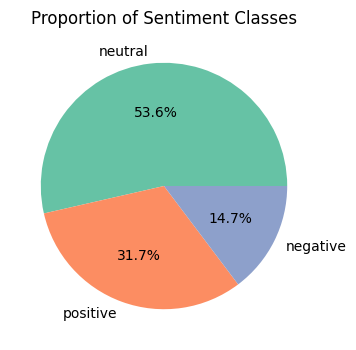

In [5]:
# Calculate the distribution
class_counts = df['Sentiment'].value_counts()

# Plot the pie chart
plt.figure(figsize=(4, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2', len(class_counts)))

# Adding title
plt.title('Proportion of Sentiment Classes')

# Show the plot
plt.show()

In [6]:
# Encode sentiment labels
sentiment_labels = pd.get_dummies(sentiments).values

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(sentences, sentiment_labels, test_size=0.2, random_state=42)

In [8]:
# Tokenize the text
tokenizer = Tokenizer(num_words=10000)  # Limit the number of unique words
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [9]:
# Pad sequences
max_length = 100  # Maximum length of sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)

In [94]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))
model.add(LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(LSTM(units=32, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(LSTM(units=16, kernel_regularizer=l2(0.01)))
model.add(Dense(3, activation='softmax'))


In [95]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [97]:
# Train the model
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5297 - loss: 3.5492 - val_accuracy: 0.5016 - val_loss: 2.4678
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.5460 - loss: 2.2164 - val_accuracy: 0.5016 - val_loss: 1.7293
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.5453 - loss: 1.5887 - val_accuracy: 0.5198 - val_loss: 1.3424


In [83]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5263 - loss: 3.7966
Test Loss: 3.7933993339538574
Test Accuracy: 0.5320786833763123
